In [75]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from scipy.integrate import quad 
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import display
import ipywidgets as widgets
import os
from ipywidgets import interact, IntSlider, Button, VBox, Output
import numpy.polynomial.polynomial as poly
from scipy import constants as const


In [76]:
# Leer el archivo CSV con separador y decimal correctos
df = pd.read_csv('Alfa_Boo_pepsi.csv', delim_whitespace=True)

wavelength = df['Wavelength'].values

flux = df['Normalised_Flux'].values

C:\Users\Jessi Dani\AppData\Local\Temp\ipykernel_11936\1875966600.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('Alfa_Boo_pepsi.csv', delim_whitespace=True)


In [77]:
df_hierro = pd.read_excel('lista de lineas Arcturus.xlsx', header=7, usecols=['l aire', 'l aire m'])

fe_1_lineas = df_hierro['l aire']
fe_1_lineas = fe_1_lineas.dropna().values

fe_1_lineas_mezclas = df_hierro['l aire m']
fe_1_lineas_mezclas = fe_1_lineas_mezclas.dropna().values

In [78]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda
    closer_data = closer_data[closer_data['abs'] <= 0.01].reset_index(drop=True)

    return closer_data.drop(['abs'],axis=1)

#Closer lines
closer_lines = find_minimums(wavelength, flux ,fe_1_lineas_mezclas)

closer_lines

,min_wave,min_flux,Fe line
0,3941.274184,0.462236,3941.2753
1,3946.997441,0.239609,3946.9949
2,3948.098023,0.181945,3948.0973
3,4000.460484,0.138299,4000.4572
4,4001.667965,0.111566,4001.6617
...,...,...,...
258,8804.630241,0.493822,8804.6258
259,8838.421982,0.388838,8838.4290
260,9024.360841,0.688184,9024.3691
261,9103.636586,0.824618,9103.6375


In [79]:
def width_minimums(closer_lines, wave, flux, width):
    local_points = []
    for each in closer_lines['min_wave']:
        mask = (wave > each - width) & (wave < each + width)
        local_points.append(pd.DataFrame({
            'Wave': wave[mask],
            'Flux': flux[mask]
        }))
    return local_points

local_points = width_minimums(closer_lines, wavelength, flux, width=0.05)


Filtro usando la segunda derivada

In [80]:
def Fit_derivates(local_points,closer_lines):
    values = []
    fit = []
    local = []

    for i in range(0,len(local_points)):

        data_wave, data_flux = local_points[i]['Wave'], local_points[i]['Flux'] #The index i correspond at one line in the lambda_list of lines 

        #Internal rise, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #take the conditional for the division in zero

        #Polynomial Fit is better for numerical aproximation than polyfit
        pol = Polynomial.fit(wave_scaled, data_flux, 4)

        #Scaled coeficients of fit
        param = pol.convert().coef

        #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
        d_param = poly.polyder(param) #First
        d2_param = poly.polyder(d_param) #Second

        flux_fit = poly.polyval(wave_scaled,param) #Evaluate the fit

        #First condition: The parameter of the order two polynomium need to be positive.
        #Second condition (for eliminate lineal terms): The distance between the initial and the final point need to be less than the half of depth
        #In other words, the final point need to be higher than the half of the distance between extreme points

        if d2_param[0]>0 and (data_flux.iloc[-1])>=(np.abs(data_flux.iloc[0]-data_flux.iloc[-1])/2):

            values.append(pd.DataFrame([[closer_lines['Fe line'].iloc[i],closer_lines['min_wave'].iloc[i],closer_lines['min_flux'].iloc[i]]])) 
            fit.append(flux_fit)
            local.append(local_points[i])

    Values = pd.concat(values,axis=0).reset_index(drop=True)

    Values.columns = ["Line Fe I",'min_wave','min_flux']

    return Values,fit,local

Values,fit,local = Fit_derivates(local_points,closer_lines)

Values

,Line Fe I,min_wave,min_flux
0,3941.2753,3941.274184,0.462236
1,3946.9949,3946.997441,0.239609
2,3948.0973,3948.098023,0.181945
3,4000.4572,4000.460484,0.138299
4,4001.6617,4001.667965,0.111566
...,...,...,...
258,8804.6258,8804.630241,0.493822
259,8838.4290,8838.421982,0.388838
260,9024.3691,9024.360841,0.688184
261,9103.6375,9103.636586,0.824618


In [81]:
# Values.to_excel('valores_prueba.xlsx',index=False)

In [82]:

# import tkinter as tk
# from tkinter import ttk
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
# import numpy as np

# class OutlierViewer:
#     def __init__(self, root, local_points, values,fit):
#         self.root = root
#         self.root.title("Visualizador de las líneas de Hierro I")
#         self.local_points = local_points
#         self.values = values
#         self.fit = fit
#         self.index = values.index.values
#         self.current_index = 0
    
#         self.setup_ui()
#         self.update_plot()

#     def setup_ui(self):
#         main_frame = ttk.Frame(self.root, padding="10")
#         main_frame.pack(fill=tk.BOTH, expand=True)
    
#         control_frame = ttk.Frame(main_frame)
#         control_frame.pack(fill=tk.X, pady=10)
    
#         ttk.Label(control_frame, text="Índice de la línea:").pack(side=tk.LEFT, padx=5)
#         self.slider = ttk.Scale(
#             control_frame,
#             from_=0,
#             to=len(self.index)-1,
#             orient=tk.HORIZONTAL,
#             command=self.on_slider_move
#         )
#         self.slider.pack(side=tk.LEFT, expand=True, fill=tk.X, padx=5)
    
#         self.spinbox = ttk.Spinbox(
#             control_frame,
#             from_=0,
#             to=len(self.index)-1,
#             width=5,
#             command=self.on_spinbox_change
#         )
#         self.spinbox.pack(side=tk.LEFT, padx=5)
#         self.spinbox.bind("<Return>", self.on_spinbox_change)
    
#         nav_frame = ttk.Frame(control_frame)
#         nav_frame.pack(side=tk.LEFT, padx=10)
    
#         ttk.Button(nav_frame, text="← Last", command=self.prev_plot).pack(side=tk.LEFT)
#         ttk.Button(nav_frame, text="Next →", command=self.next_plot).pack(side=tk.LEFT, padx=5)
    
#         graph_frame = ttk.Frame(main_frame)
#         graph_frame.pack(fill=tk.BOTH, expand=True)
    
#         self.fig, self.ax = plt.subplots(figsize=(10, 6))
#         self.canvas = FigureCanvasTkAgg(self.fig, master=graph_frame)
#         self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
    
#         self.toolbar = NavigationToolbar2Tk(self.canvas, graph_frame)
#         self.toolbar.update()
#         self.canvas._tkcanvas.pack(fill=tk.BOTH, expand=True)

#     def on_slider_move(self, event=None):
#         self.current_index = int(float(self.slider.get()))
#         self.spinbox.delete(0, tk.END)
#         self.spinbox.insert(0, str(self.current_index))
#         self.update_plot()

#     def on_spinbox_change(self, event=None):
#         try:
#             new_index = int(self.spinbox.get())
#             if 0 <= new_index < len(self.index):
#                 self.current_index = new_index
#                 self.slider.set(self.current_index)
#                 self.update_plot()
#         except ValueError:
#             pass

#     def prev_plot(self):
#         if self.current_index > 0:
#             self.current_index -= 1
#             self.slider.set(self.current_index)
#             self.spinbox.delete(0, tk.END)
#             self.spinbox.insert(0, str(self.current_index))
#             self.update_plot()

#     def next_plot(self):
#         if self.current_index < len(self.index)-1:
#             self.current_index += 1
#             self.slider.set(self.current_index)
#             self.spinbox.delete(0, tk.END)
#             self.spinbox.insert(0, str(self.current_index))
#             self.update_plot()

#     #Graficas
#     def update_plot(self):
#         j = self.current_index
#         self.ax.clear()
    
#         # Gráfica principal
#         self.ax.plot(
#             self.local_points[j]['Wave'],
#             self.local_points[j]['Flux'],
#             color='pink',
#             label='Spectrum'
#         )
    
#         #Closer lines
#         self.ax.plot(
#             self.local_points[j]['Wave'],
#             self.fit[j],
#             color='purple',
#             label='Fit',
#             marker='.',
#         )
    
#         #Fe I line
#         self.ax.scatter(
#             self.values["Line Fe I"][j],
#             self.values['min_flux'][j],
#             color='red',
#             label='Fe I',
#             s=100
#         )

#         #Fe I line
#         self.ax.scatter(
#             self.values['min_wave'][j],
#             self.values["min_flux"][j],
#             color='purple',
#             s=100
#         )
    
#         #Vainitas del gráfico
#         self.ax.set_title(f'Visualizador - Índice {self.index[j]} - Longitud de onda {self.values["Line Fe I"][j]} Å')
#         self.ax.set_xlabel(r'Wavelength $(\mathring{A})$')
#         self.ax.set_ylabel('Flux')
#         self.ax.legend()
#         self.ax.grid(True)
    
#         self.canvas.draw()


# if __name__ == "__main__":
#     root = tk.Tk()
#     root.geometry("900x700")


#     app = OutlierViewer(root, local, Values,fit)

#     root.mainloop()



In [83]:
df_hierro_revisar = pd.read_excel('linea_mezclas_despues_filtro.xlsx', header=2, usecols=['l aire m'])
fe_1_lineas_mezclas_r = df_hierro_revisar['l aire m']
fe_1_lineas_mezclas_r = fe_1_lineas_mezclas_r.dropna().values

In [84]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda

    return closer_data.drop(['abs'],axis=1)


closer_lines_r = find_minimums(wavelength, flux ,fe_1_lineas_mezclas_r)

closer_lines_r

,min_wave,min_flux,Fe line
0,3941.274184,0.462236,3941.2753
1,3946.997441,0.239609,3946.9949
2,3948.098023,0.181945,3948.0973
3,4000.460484,0.138299,4000.4572
4,4001.667965,0.111566,4001.6617
...,...,...,...
326,8975.377579,0.428425,8975.4007
327,9024.360841,0.688184,9024.3691
328,9103.636586,0.824618,9103.6375
329,9112.252960,0.879193,9112.2422


In [85]:
def width_minimums(closer_lines, wave, flux, width):
    local_points = []
    for each in closer_lines['min_wave']:
        mask = (wave > each - width) & (wave < each + width)
        local_points.append(pd.DataFrame({
            'Wave': wave[mask],
            'Flux': flux[mask]
        }))
    return local_points

local_points_r = width_minimums(closer_lines_r, wavelength, flux, width=0.05)


In [86]:
const.c

299792458.0

In [ ]:
def Fit_derivates_r(local_points, lamda_list):
    values = []
    fit = []
    local = []  # 👈 agregamos esta lista

    for i in range(len(local_points)):
        # Extrae las columnas correctamente, según si el elemento es un DataFrame o un dict
        try:
            data_wave = local_points[i]['Wave']
            data_flux = local_points[i]['Flux']
        except (KeyError, TypeError):
            print(f"⚠️ Error: local_points[{i}] no tiene columnas 'Wave' y 'Flux'")
            continue  # salta este ciclo si el formato no es correcto

        # Estandarización
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave)
        wave_scaled = (data_wave - wave_mean) / wave_std if wave_std != 0 else data_wave

        # Ajuste polinómico de orden 4
        pol = Polynomial.fit(wave_scaled, data_flux, 4)
        param = pol.convert().coef

        # Derivadas
        d_param = poly.polyder(param)   # primera
        d2_param = poly.polyder(d_param)  # segunda
        d3_param = poly.polyder(d2_param)  # tercera

        flux_fit = poly.polyval(wave_scaled, param)

        # Encuentra los mínimos locales
        roots = poly.polyroots(d_param).real
        valid_roots = np.array([x for x in roots if poly.polyval(x, d2_param) > 0])

        if valid_roots.size > 0:
            value_roots = pol(valid_roots)
            minimal_root = valid_roots[np.argmin(value_roots)], np.min(value_roots)

            # Convierte de la escala normalizada a la longitud de onda real
            lamda_obs = [round(minimal_root[0]*wave_std + wave_mean, 4), minimal_root[1]]

            # Tercer derivada (perfil del bisector)
            def Third_Derivate(second, third):
                return -((third) / (3 * (second ** 2))) * (const.c / lamda_obs[0])

            # Evalúa segundas y terceras derivadas reescaladas
            d2 = (poly.polyval(minimal_root[0], d2_param) / (wave_std ** 2)) * (lamda_obs[0] ** 2)
            d3 = -(Third_Derivate(d2, poly.polyval(minimal_root[0], d3_param) / (wave_std ** 3))) * (const.c / lamda_obs[0])

            # Blueshift y velocidad
            blueshift = ((lamda_obs[0] / lamda_list[i]) - 1)
            velocity = blueshift * const.c

            # Guarda resultados
            values.append(pd.DataFrame([[lamda_list[i], lamda_obs[0], lamda_obs[1],
                                         velocity, d2, d3, blueshift]]))
            fit.append(flux_fit)
            local.append(local_points[i])  # 👈 añadimos también el local

    # Unimos los resultados
    Values = pd.concat(values, axis=0).reset_index(drop=True)
    Values.columns = ["L teórica", "L observada", "Flux",
                      "Velocidad", "Core curvature", "Bisector slope", "Z"]

    return Values, fit, local

Values_r, fit_r,local_r = Fit_derivates_r(local_points_r, fe_1_lineas_mezclas_r)

In [90]:
Values_r

,L teórica,L observada,Flux,Velocidad,Core curvature,Bisector slope,Z
0,3941.2753,3941.2756,0.457658,23,4.770470e+09,1.525776e-07,7.611749e-08
1,3946.9949,3946.9967,0.238655,137,4.319343e+09,-1.148017e-07,4.560432e-07
2,3948.0973,3948.0988,0.182978,114,3.370306e+09,3.659266e-08,3.799298e-07
3,4000.4572,4000.4577,0.137933,37,2.717649e+09,-1.112911e-08,1.249857e-07
4,4001.6617,4001.6658,0.109383,307,1.903568e+09,-6.157507e-07,1.024574e-06
...,...,...,...,...,...,...,...
326,8975.4007,8975.3828,0.427977,-598,2.612364e+09,2.641449e-09,-1.994340e-06
327,9024.3691,9024.3579,0.688809,-372,2.862807e+09,7.922961e-09,-1.241084e-06
328,9103.6375,9103.6336,0.824471,-128,2.706549e+09,1.067947e-08,-4.284002e-07
329,9112.2422,9112.2497,0.879167,247,4.113908e+08,-3.672112e-07,8.230686e-07


In [96]:
# DIAGNÓSTICO COMPLETO
print("=== ESTRUCTURA DE local_r ===")
print(f"Tipo: {type(local_r)}")
print(f"Longitud: {len(local_r)}")
if len(local_r) > 0:
    print(f"Primer elemento tipo: {type(local_r[0])}")
    print(f"Columnas disponibles: {local_r[0].keys() if hasattr(local_r[0], 'keys') else 'No es dict'}")
    print(f"Ejemplo de datos Wave: {local_r[0]['Wave'][:3] if 'Wave' in local_r[0] else 'No hay Wave'}")
    print(f"Ejemplo de datos Flux: {local_r[0]['Flux'][:3] if 'Flux' in local_r[0] else 'No hay Flux'}")

print("\n=== ESTRUCTURA DE Values_r ===")
print(f"Tipo: {type(Values_r)}")
print(f"Shape: {Values_r.shape}")
print(f"Columnas: {Values_r.columns.tolist()}")
print(f"Primeras filas:")
print(Values_r.head())

print("\n=== VERIFICACIÓN CRÍTICA DE FLUX ===")
print(f"Valores mínimos de Flux: {Values_r['Flux'].min()}")
print(f"Valores máximos de Flux: {Values_r['Flux'].max()}")
print(f"1 - Flux mínimo: {1 - Values_r['Flux'].max()}")
print(f"1 - Flux máximo: {1 - Values_r['Flux'].min()}")

print("\n=== VERIFICACIÓN DE OTRAS COLUMNAS ===")
print(f"¿Existe 'Core curvature'? {'Core curvature' in Values_r.columns}")
print(f"¿Existe 'Bisector slope'? {'Bisector slope' in Values_r.columns}")
print(f"¿Existe 'Velocidad'? {'Velocidad' in Values_r.columns}")

=== ESTRUCTURA DE local_r ===
Tipo: <class 'list'>
Longitud: 331
Primer elemento tipo: <class 'pandas.core.frame.DataFrame'>
Columnas disponibles: Index(['Wave', 'Flux'], dtype='object')
Ejemplo de datos Wave: 0    3941.226396
1    3941.234362
2    3941.242327
Name: Wave, dtype: float64
Ejemplo de datos Flux: 0    0.701876
1    0.645301
2    0.592340
Name: Flux, dtype: float64

=== ESTRUCTURA DE Values_r ===
Tipo: <class 'pandas.core.frame.DataFrame'>
Shape: (331, 7)
Columnas: ['L teórica', 'L observada', 'Flux', 'Velocidad', 'Core curvature', 'Bisector slope', 'Z']
Primeras filas:
   L teórica  L observada      Flux  Velocidad  Core curvature  \
0  3941.2753    3941.2756  0.457658         23    4.770470e+09   
1  3946.9949    3946.9967  0.238655        137    4.319343e+09   
2  3948.0973    3948.0988  0.182978        114    3.370306e+09   
3  4000.4572    4000.4577  0.137933         37    2.717649e+09   
4  4001.6617    4001.6658  0.109383        307    1.903568e+09   

   Bisector sl

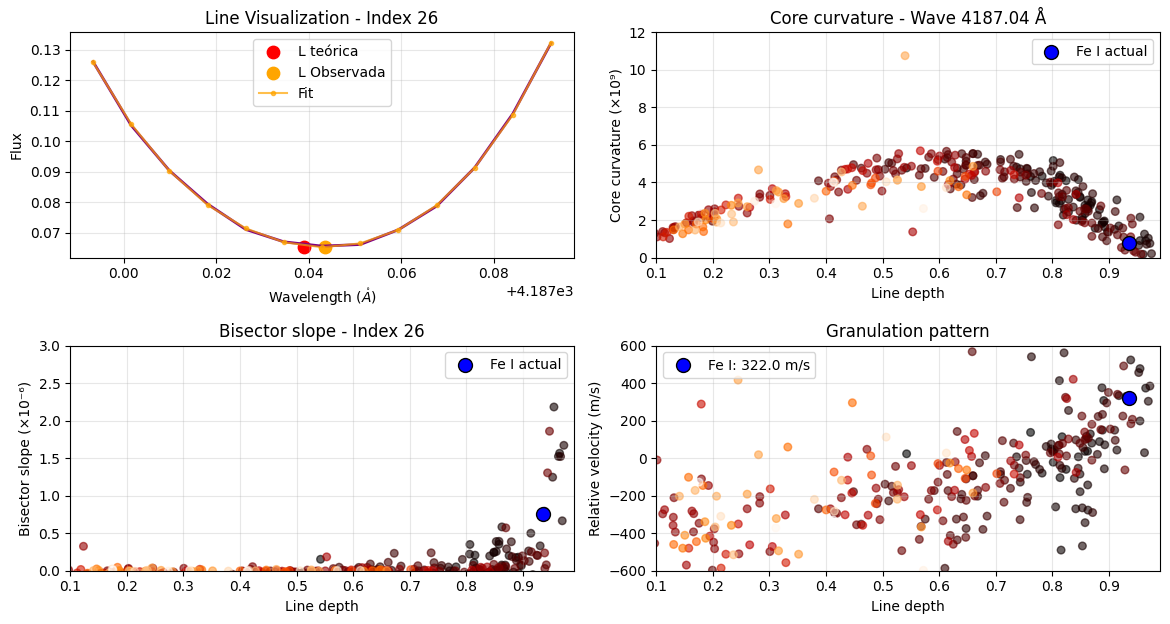

In [101]:
import tkinter as tk
from tkinter import ttk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
import numpy as np

class OutlierViewer:
    def __init__(self, root, local_r, Values_r, fit_r):
        self.root = root
        self.root.title("Visualizer of Fe I lines identification")
        self.local_r = local_r
        self.values_r = Values_r  # Cambié de Values_r a values_r para consistencia
        self.fit_r = fit_r
        self.index = self.values_r.index.values  # CORREGIDO: agregué self.
        self.current_index = 0
       
        self.setup_ui()
        self.update_plot()
    
    def setup_ui(self):
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.pack(fill=tk.BOTH, expand=True)
        
        control_frame = ttk.Frame(main_frame)
        control_frame.pack(fill=tk.X, pady=10)
        
        ttk.Label(control_frame, text="Index of the line:").pack(side=tk.LEFT, padx=5)
        self.slider = ttk.Scale(
            control_frame,
            from_=0,
            to=len(self.index)-1,
            orient=tk.HORIZONTAL,
            command=self.on_slider_move
        )
        self.slider.pack(side=tk.LEFT, expand=True, fill=tk.X, padx=5)
        
        self.spinbox = ttk.Spinbox(
            control_frame,
            from_=0,
            to=len(self.index)-1,
            width=5,
            command=self.on_spinbox_change
        )
        self.spinbox.pack(side=tk.LEFT, padx=5)
        self.spinbox.bind("<Return>", self.on_spinbox_change)
        
        nav_frame = ttk.Frame(control_frame)
        nav_frame.pack(side=tk.LEFT, padx=10)
        
        ttk.Button(nav_frame, text="← Last", command=self.prev_plot).pack(side=tk.LEFT)
        ttk.Button(nav_frame, text="Next →", command=self.next_plot).pack(side=tk.LEFT, padx=5)
     
        graph_frame = ttk.Frame(main_frame)
        graph_frame.pack(fill=tk.BOTH, expand=True)
       
        # Crear figura con dos subplots - CORREGIDO: eliminar duplicación
        self.fig, self.axs = plt.subplots(2, 2, figsize=(20, 14))
        self.ax1, self.ax2, self.ax3, self.ax4 = self.axs.flat
        
        self.canvas = FigureCanvasTkAgg(self.fig, master=graph_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        self.toolbar = NavigationToolbar2Tk(self.canvas, graph_frame)
        self.toolbar.update()
        self.canvas._tkcanvas.pack(fill=tk.BOTH, expand=True)
    
    def on_slider_move(self, event=None):
        self.current_index = int(float(self.slider.get()))
        self.spinbox.delete(0, tk.END)
        self.spinbox.insert(0, str(self.current_index))
        self.update_plot()
    
    def on_spinbox_change(self, event=None):
        try:
            new_index = int(self.spinbox.get())
            if 0 <= new_index < len(self.index):
                self.current_index = new_index
                self.slider.set(self.current_index)
                self.update_plot()
        except ValueError:
            pass
    
    def prev_plot(self):
        if self.current_index > 0:
            self.current_index -= 1
            self.slider.set(self.current_index)
            self.spinbox.delete(0, tk.END)
            self.spinbox.insert(0, str(self.current_index))
            self.update_plot()
    
    def next_plot(self):
        if self.current_index < len(self.index)-1:
            self.current_index += 1
            self.slider.set(self.current_index)
            self.spinbox.delete(0, tk.END)
            self.spinbox.insert(0, str(self.current_index))
            self.update_plot()
    
    def update_plot(self):
        j = self.current_index
        
        self.ax1.clear()
        self.ax2.clear()
        self.ax3.clear()
        self.ax4.clear()
        
        # Plot 1 - Esta está bien
        self.ax1.plot(self.local_r[j]['Wave'],
                    self.local_r[j]['Flux'],
                    c='purple', linewidth=2)

        self.ax1.scatter(
            self.values_r['L teórica'].iloc[j],
            self.values_r["Flux"].iloc[j],
            color='red',
            s=80,
            label='L teórica'
        )

        self.ax1.scatter(
            self.values_r['L observada'].iloc[j],
            self.values_r["Flux"].iloc[j],
            color='orange',
            s=80,
            label='L Observada'
        )

        self.ax1.plot(self.local_r[j]['Wave'],
                    self.fit_r[j],
                    c='orange',
                    marker='.',
                    label='Fit',
                    alpha=0.7)
        
        self.ax1.set_title(f'Line Visualization - Index {self.index[j]}')
        self.ax1.set_xlabel(r'Wavelength $(\mathring{A})$')
        self.ax1.set_ylabel('Flux')
        self.ax1.grid(True, alpha=0.3)
        self.ax1.legend()
        
        # Calcular line depth
        line_depth = 1 - self.values_r['Flux']
        
        # Plot 2 - Core curvature (reescalar)
        self.ax2.scatter(line_depth,
                        self.values_r['Core curvature'] / 1e9,  # Convertir a unidades de 10⁹
                        c=self.values_r["L observada"],
                        cmap='gist_heat', 
                        alpha=0.6,
                        s=30)
        
        self.ax2.scatter(
            line_depth.iloc[j],
            self.values_r['Core curvature'].iloc[j] / 1e9,  # Misma conversión
            color='blue',
            edgecolor='black',
            label='Fe I actual',
            s=100
        )
        
        self.ax2.set_title(f'Core curvature - Wave {self.values_r["L teórica"].iloc[j]:.2f} Å')
        self.ax2.set_xlabel('Line depth')
        self.ax2.set_ylabel('Core curvature (×10⁹)')  # Indicar la escala
        self.ax2.set_xlim(0.1, 0.99)  # Ajustar según tus datos
        self.ax2.set_ylim(0, 12)  # Ajustar según tus datos
        self.ax2.grid(True, alpha=0.3)
        self.ax2.legend()
        
        # Plot 3 - Bisector slope (reescalar)
        self.ax3.scatter(line_depth,
                        self.values_r['Bisector slope'] * 1e6,  # Convertir a unidades de 10⁻⁶
                        c=self.values_r["L observada"],
                        cmap='gist_heat', 
                        alpha=0.6,
                        s=30)
        
        self.ax3.scatter(
            line_depth.iloc[j],
            self.values_r['Bisector slope'].iloc[j] * 1e6,  # Misma conversión
            color='blue',
            edgecolor='black',
            label='Fe I actual',
            s=100
        )
        
        self.ax3.set_title(f'Bisector slope - Index {j}')
        self.ax3.set_xlabel('Line depth')
        self.ax3.set_ylabel('Bisector slope (×10⁻⁶)')  # Indicar la escala
        self.ax3.set_xlim(0.1, 0.99)  # Ajustar según tus datos
        self.ax3.set_ylim(0, 3)  # Ajustar según tus datos
        self.ax3.grid(True, alpha=0.3)
        self.ax3.legend()

        # Plot 4 - Velocidad (esta debería estar bien)
        self.ax4.scatter(line_depth,
                        self.values_r['Velocidad'],
                        c=self.values_r["L observada"],
                        cmap='gist_heat', 
                        alpha=0.6,
                        s=30)
        
        self.ax4.scatter(
            line_depth.iloc[j],
            self.values_r['Velocidad'].iloc[j],
            color='blue',
            edgecolor='black',
            label=f'Fe I: {self.values_r["Velocidad"].iloc[j]:.1f} m/s',
            s=100
        )
        
        self.ax4.set_title(f'Granulation pattern')
        self.ax4.set_xlabel('Line depth')
        self.ax4.set_ylabel('Relative velocity (m/s)')
        self.ax4.set_xlim(0.1, 0.99)  # Ajustar según tus datos
        self.ax4.set_ylim(-600, 600)  # Ajustar según tus datos
        self.ax4.grid(True, alpha=0.3)
        self.ax4.legend()

        self.fig.tight_layout()
        self.canvas.draw()

if __name__ == "__main__":
    root = tk.Tk()
    root.geometry("1200x700") 
    
    # Asegúrate de que estas variables estén definidas antes de crear la app
    app = OutlierViewer(root, local_r, Values_r, fit_r)
    root.mainloop()

    